In [2]:
import pandas as pd
import csv
import os

### Download data

In [ ]:
from urllib.request import urlretrieve

# 下载 metadata.parquet 文件
table_url = 'https://huggingface.co/datasets/poloclub/diffusiondb/resolve/main/metadata.parquet'
urlretrieve(table_url, 'metadata.parquet')

# 读取 parquet 文件
metadata_df = pd.read_parquet('metadata.parquet')

# 选择需要的列
columns_to_keep = ['prompt', 'step', 'cfg', 'sampler', 'width', 'height']
filtered_df = metadata_df[columns_to_keep]

# 使用 iloc 选择第 20,000 至第 79,999 行数据
subset_df = filtered_df.iloc[20000:80000]

# 将数据保存为 CSV 文件
subset_df.to_csv('../data/diffusiondb_metadata_subset.csv', index=False)

: 

### Preprocessing

In [ ]:
from transformers import AutoTokenizer

# 加载预训练的分词器，例如使用 BERT 的分词器
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

# 读取 CSV 文件
df = pd.read_csv('../data/diffusiondb_metadata_subset.csv')

# 定义一个函数，计算文本的 token 数量
def count_tokens(text):
    # 使用分词器将文本编码为 token ID，并获取 token 数量
    tokens = tokenizer.encode(text, add_special_tokens=False)
    return len(tokens)

df['prompt'] = df['prompt'].astype(str)
# 应用该函数到 'prompt' 列，创建一个新的 'token_count' 列
df['token_count'] = df['prompt'].apply(count_tokens)

# 过滤 'cfg' 列大于 20 且 'width' 和 'height' 列之积大于 2500 的行
df = df[(df['cfg'] >= 0)  & (df['cfg'] <= 20) & (df['width'] < 2500) & (df['height'] < 2500)]

# 计算 'step' 列的最小值和最大值
min_step = df['step'].min()
max_step = df['step'].max()

# 定义一个函数，将 'step' 值映射到新的范围
def scale_step(value):
    if value < 50:
        return int((value - min_step) / (50 - min_step) * 20)
    else:
        return int((value - 50) / (max_step - 50) * (50 - 20) + 20)

# 使用 apply 方法应用 scale_step 函数，并将结果赋值回 'step' 列
df['step'] = df['step'].apply(scale_step)

# 过滤掉 'step' 列值为 0 的行
df = df[df['step'] != 0]

df.insert(0, 'id', range(1, len(df) + 1))

# 保存结果到新的 CSV 文件
df.to_csv('../data/all.csv', index=False)

In [ ]:
from sklearn.model_selection import train_test_split

df = pd.read_csv('../data/all.csv')

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

val1_df, train_df = train_test_split(train_df, test_size=0.99, random_state=42)
val10_df, train_df = train_test_split(train_df, test_size=0.9, random_state=42)  

train_df.to_csv('../data/train.csv', index=False)
val1_df.to_csv('../data/train_mini.csv', index=False)
val10_df.to_csv('../data/train_small.csv', index=False)
test_df.to_csv('../data/test.csv', index=False)

In [ ]:
input_file = '../data/train_mini.csv'
output_file = '../experiment/input/mini.csv'

with open(input_file, mode='r', newline='') as infile:
    reader = csv.reader(infile)
    rows = list(reader)


header = rows[0] + ['timestamp']
# 添加 timestamp 为 0 的数据到每一行
for row in rows[1:]:
    row.append(0)

with open(output_file, mode='w', newline='') as outfile:
    writer = csv.writer(outfile)
    writer.writerow(header)
    writer.writerows(rows[1:])

print(f"Updated CSV file saved as {output_file}")

In [3]:
input_file = '../data/train_small.csv'
output_dir = '../experiment/input'

# 一次读入所有行
with open(input_file, mode='r', newline='') as infile:
    reader = csv.reader(infile)
    rows = list(reader)

header = rows[0] + ['timestamp']
data_rows = rows[1:]

# 每块的大小
chunk_size = 1000
for i in range(0, len(data_rows), chunk_size):
    chunk = data_rows[i:i + chunk_size]

    # 添加 timestamp=0
    for row in chunk:
        row.append(0)

    output_file = os.path.join(output_dir, f'small_{i // chunk_size}.csv')
    with open(output_file, mode='w', newline='') as outfile:
        writer = csv.writer(outfile)
        writer.writerow(header)
        writer.writerows(chunk)

    print(f"Saved {len(chunk)} rows to {output_file}")

Saved 1000 rows to ../experiment/input/small_0.csv
Saved 1000 rows to ../experiment/input/small_1.csv
Saved 1000 rows to ../experiment/input/small_2.csv
Saved 1000 rows to ../experiment/input/small_3.csv
Saved 690 rows to ../experiment/input/small_4.csv


### Analysis

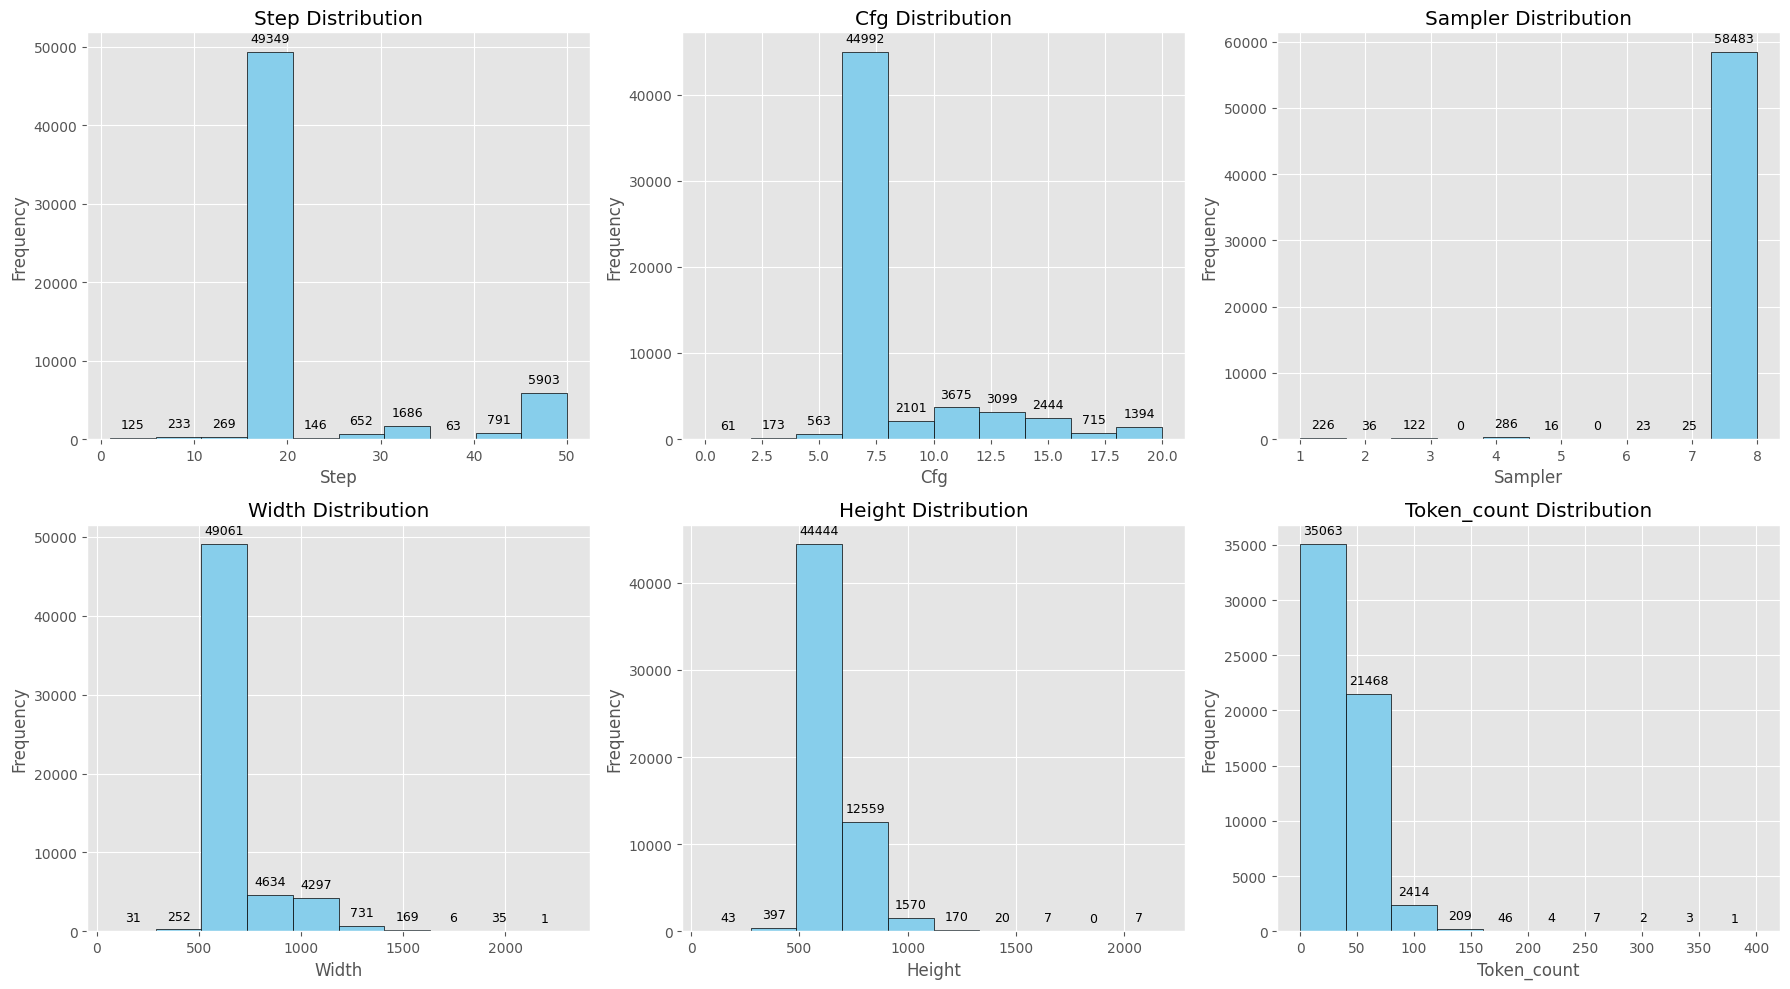

In [2]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# 读取 CSV 文件，确保第一行作为列名
df = pd.read_csv('../data/all.csv')

# 将 'cfg' 列转换为浮点数类型，处理可能的转换错误
df['cfg'] = df['cfg'].astype(float)

# 设置绘图风格
plt.style.use('ggplot')

# 创建子图
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# 变量列表
variables = ['step', 'cfg', 'sampler', 'width', 'height', 'token_count']

# 绘制每个变量的直方图
for i, var in enumerate(variables):
    ax = axes[i // 3, i % 3]
    n, bins, patches = ax.hist(df[var], bins=10, color='skyblue', edgecolor='black')
    ax.set_title(f'{var.capitalize()} Distribution')
    ax.set_xlabel(var.capitalize())
    ax.set_ylabel('Frequency')
    
    # 在每个 bin 上方添加数量标签
    for patch, count in zip(patches, n):
        height = patch.get_height()
        ax.annotate(f'{int(count)}', xy=(patch.get_x() + patch.get_width() / 2, height),
                    xytext=(0, 5), textcoords='offset points',
                    ha='center', va='bottom', fontsize=9)
    

# 调整布局
plt.tight_layout()
plt.show()

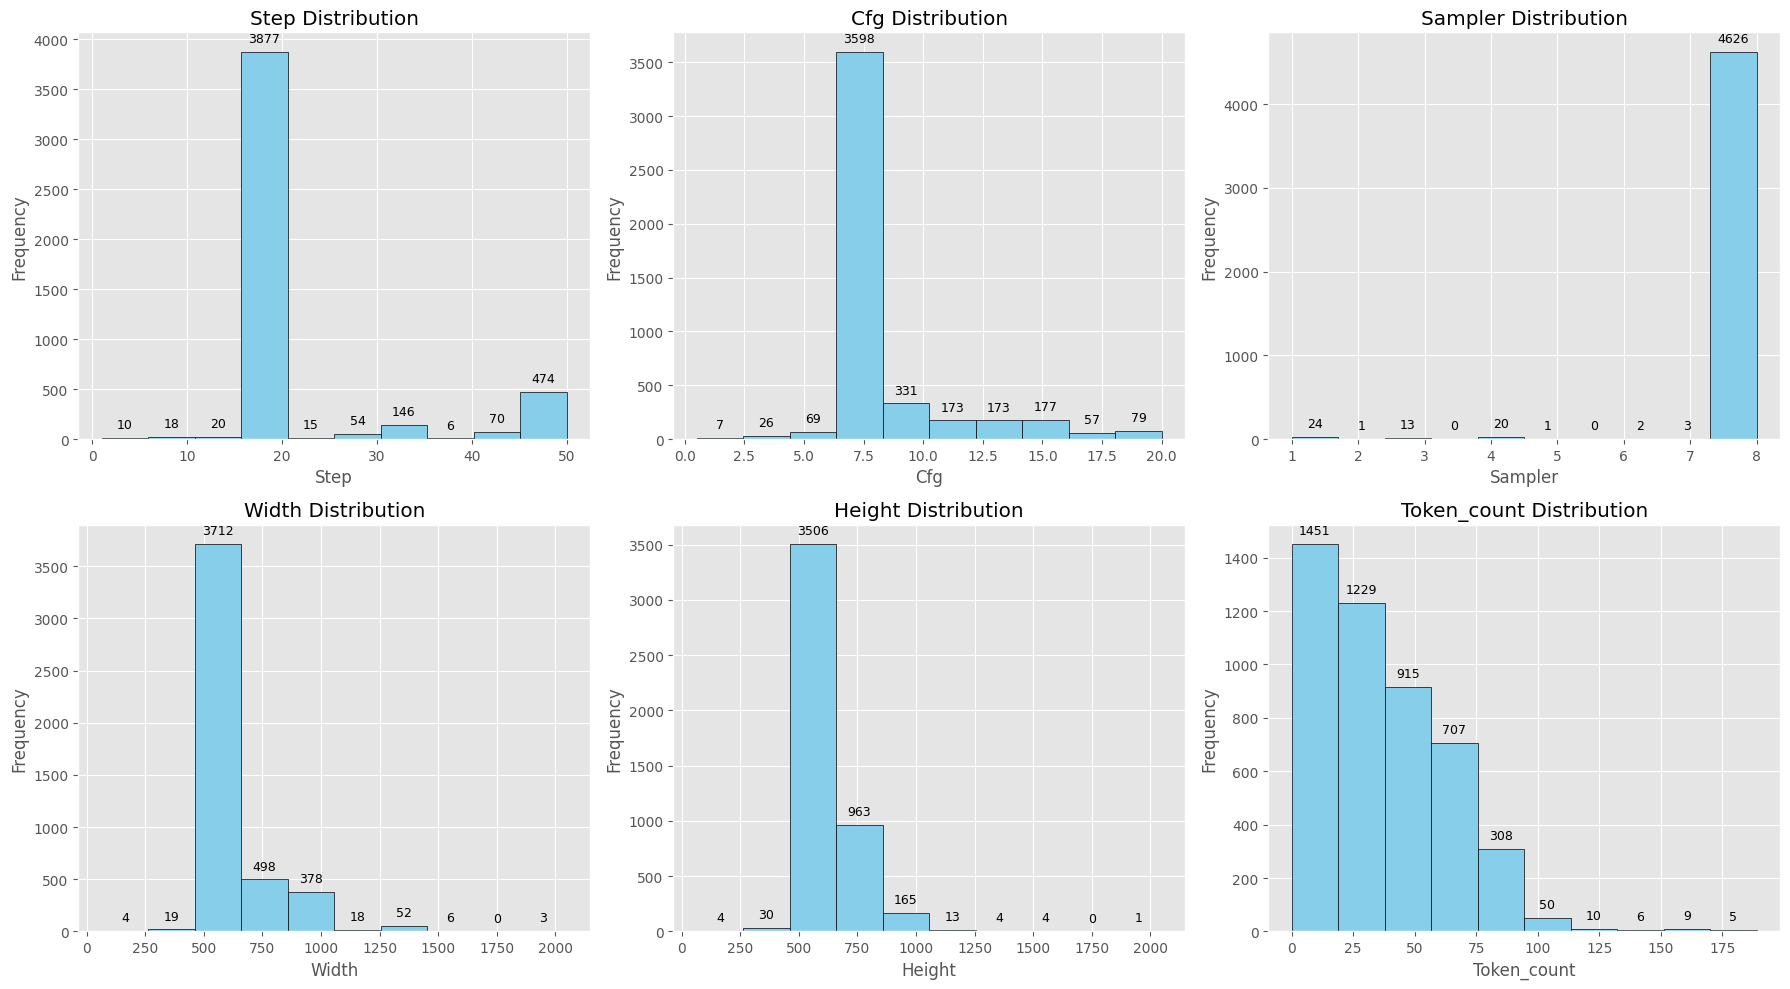

In [5]:
# 读取 CSV 文件，确保第一行作为列名
df = pd.read_csv('../data/train_small.csv')

# 将 'cfg' 列转换为浮点数类型，处理可能的转换错误
df['cfg'] = df['cfg'].astype(float)

# 设置绘图风格
plt.style.use('ggplot')

# 创建子图
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# 变量列表
variables = ['step', 'cfg', 'sampler', 'width', 'height', 'token_count']

# 绘制每个变量的直方图
for i, var in enumerate(variables):
    ax = axes[i // 3, i % 3]
    n, bins, patches = ax.hist(df[var], bins=10, color='skyblue', edgecolor='black')
    ax.set_title(f'{var.capitalize()} Distribution')
    ax.set_xlabel(var.capitalize())
    ax.set_ylabel('Frequency')
    
    # 在每个 bin 上方添加数量标签
    for patch, count in zip(patches, n):
        height = patch.get_height()
        ax.annotate(f'{int(count)}', xy=(patch.get_x() + patch.get_width() / 2, height),
                    xytext=(0, 5), textcoords='offset points',
                    ha='center', va='bottom', fontsize=9)
    

# 调整布局
plt.tight_layout()
plt.show()